In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from xml.etree import ElementTree as ET
from prop_eval import mabo
from prop_eval import detection_rate

In [2]:
def edge_boxes(image, model, num_boxes = 80):

    edge_detection = cv2.ximgproc.createStructuredEdgeDetection(model)
    rgb_im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    edges = edge_detection.detectEdges(np.float32(rgb_im) / 255.0)

    orimap = edge_detection.computeOrientation(edges)
    edges = edge_detection.edgesNms(edges, orimap)

    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setMaxBoxes(num_boxes)
    boxes, scores = edge_boxes.getBoundingBoxes(edges, orimap)

    return boxes, scores

def show_edge_boxes(image, rects):
    imOut = image.copy()

    # itereate over all the region proposals
    for _, rect in enumerate(rects):
        # draw rectangle for region proposal
        x, y, w, h = rect
        color = list(np.random.random(size=3) * 256)
        cv2.rectangle(imOut, (x, y), (x+w, y+h), color, 2, cv2.LINE_AA)

    plt.imshow(imOut[...,::-1])
    plt.axis('off')

In [3]:
from xml.etree import ElementTree as ET

def read_xml(path: str) -> list:  

    tree = ET.parse(path)
    root = tree.getroot()

    obj_list = []

    for obj in root.iter('object'):

        ymin = int(obj.find("bndbox/ymin").text)
        xmin = int(obj.find("bndbox/xmin").text)
        ymax = int(obj.find("bndbox/ymax").text)
        xmax = int(obj.find("bndbox/xmax").text)

        bbox = (xmin, ymin, xmax, ymax)
        obj_list.append(bbox)
    
    return obj_list

In [4]:
image_path = 'Potholes/annotated-images/img-1.jpg'
img = cv2.imread(image_path)

GT = read_xml(image_path.replace("jpg", "xml"))

mabo_result = []
recall_result = []
step = 1
boxes = np.arange(step, step * 100 + 1, step)
iou_k = 0.7

for box in boxes:
    edgeboxes, _ = edge_boxes(img, './model.yml', box)
    mabo_result.append(mabo(edgeboxes, GT, coord = 'xywh'))
    recall_result.append(detection_rate(edgeboxes, GT, iou_k, coord = 'xywh'))

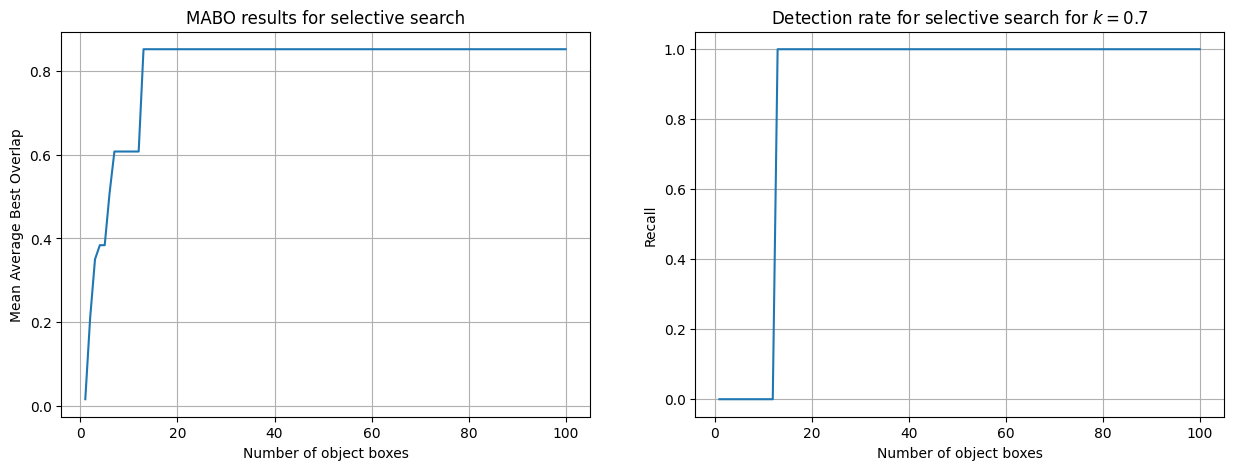

In [5]:
fig, ax = plt. subplots(1, 2)

ax[0].plot(boxes, mabo_result)
ax[0].set_xlabel("Number of object boxes")
ax[0].set_ylabel("Mean Average Best Overlap")
ax[0].set_title("MABO results for selective search")
ax[0].grid()

ax[1].plot(boxes, recall_result)
ax[1].set_xlabel("Number of object boxes")
ax[1].set_ylabel("Recall")
ax[1].set_title(rf"Detection rate for selective search for $k = {iou_k}$")
ax[1].grid()

fig.set_figheight(5)
fig.set_figwidth(15)

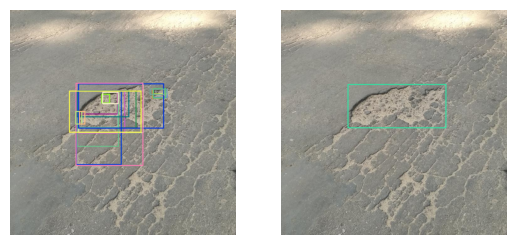

In [6]:
plt.subplot(1, 2, 1)
edgeboxes, scores = edge_boxes(img, './model.yml', 20)
show_edge_boxes(img, edgeboxes)

plt.subplot(1, 2, 2)
im_GT = np.array(GT)
im_GT[:, 2] = im_GT[:, 2] - im_GT[:, 0]
im_GT[:, 3] = im_GT[:, 3] - im_GT[:, 1]
show_edge_boxes(img, im_GT)